# Map interpolation

Interpolation is a kind of regression (and, arguably, all prediction is interpolation... so all machine learning models are maps). And we have a bunch of different nonlinear regressors available to us in `scikit-learn`. So let's apply some of them to a mapping problem.

We're going to start with a Gaussian process to model a surface. This is equivalent to kriging in the language of geostatistics. `sklearn` implements a sophisticated model, with stationary or non-stationary and isotropic or nonisotropic kernels — [read about it](https://scikit-learn.org/stable/modules/gaussian_process.html). 

[This tutorial](https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319) is worth reading.

I'm using a small dataset originally from Geoff Bohling at the Kansas Geological Survey. I can no longer find the data online, but here's what he says about it:

> Our example data consist of vertically averaged porosity values, in percent, in Zone A of the Big Bean Oil Field (fictitious, but based on real data). Porosity values are available from 85 wells distributed throughout the field, which is approximately 20 km in east-west extent and 16 km north-south. The porosities range from 12% to 17%.

[Read more about it](http://discoverspatial.in/wp-content/uploads/2018/04/IntroToGeostatistics-Geoff-Bohling.pdf)

We will look at making a map using the Scikit-Learn machine learning library with `sklearn.gaussian_process`.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

### EXERCISE

The data file is on the web at `https://www.dropbox.com/s/6dyfc4fl5slhgry/ZoneA.dat?raw=1` and `https://geocomp.s3.amazonaws.com/data/ZoneA.dat`.

Load the data from the text file into a Pandas DataFrame. <a title="Use Pandas's read_csv() method. You will need to set some arguments: sep, header, usecols, names, and dtype."><b>Hover for HINT</b></a>

We don't need all of the fields, but we at least need x, y, thickness and porosity. The top of the DataFrame should look something like this:

              x       y     thick       por
    0   12100.0  8300.0   37.1531   14.6515
    1    5300.0  8700.0   31.4993   14.5093
    
Once you have the data, can you make a KDE plot (`sns.kdeplot()`) with Seaborn?

In [2]:
# YOUR CODE HERE
fname = "https://geocomp.s3.amazonaws.com/data/ZoneA.dat"



In [1]:
import pandas as pd

fname = "https://geocomp.s3.amazonaws.com/data/ZoneA.dat"

df = pd.read_csv(fname,
                 sep=' ',
                 header=9,
                 usecols=[0, 1, 2, 3, 4],
                 names=['x', 'y', 'thick', 'por', 'perm'],
                 dtype="float64",
                 na_values=[-999.9999],
                )

df.head()

,x,y,thick,por,perm
0,12100.0,8300.0,37.1531,14.6515,2.8547
1,5300.0,8700.0,31.4993,14.5093,NaN
2,3500.0,13900.0,36.9185,14.0639,NaN
3,5100.0,1900.0,24.0156,15.1084,1.1407
4,9900.0,13700.0,35.0411,13.9190,NaN


<AxesSubplot:xlabel='por', ylabel='Density'>

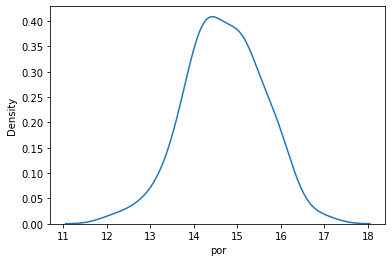

In [2]:
import seaborn as sns

sns.kdeplot(df.por)

This next bit looks a bit unpleasant, but we're just getting out min and max values for the x and y columns.

In [3]:
extent = x_min, x_max, y_min, y_max = [df.x.min() - 1000, df.x.max() + 1000,
                                       df.y.min() - 1000, df.y.max() + 1000]

### EXERCISE

Make a map of the porosity data. Use the colour of the points to indicate porosity, and use the size to indicate thickness of the zone.

Add a colourbar, title, and other annotation.

In [4]:
# YOUR CODE HERE



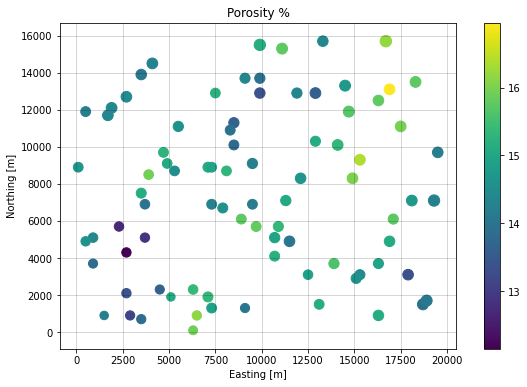

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df.x, df.y, c=df.por, s=3*df.thick)
plt.colorbar(scatter)
ax.set_aspect(1)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Porosity %')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a grid

Now we can make a regular grid:

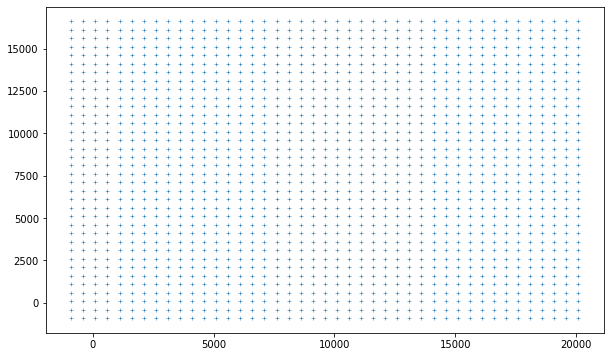

In [8]:
# Notice the order of x (columns) and y (rows)!
grid_y, grid_x = np.mgrid[y_min:y_max:500, x_min:x_max:500]

# Use *shape* argument to specify the *number* (not size) of bins:
# grid_y, grid_x = np.mgrid[y_min:y_max:100j, x_min:x_max:100j]

plt.figure(figsize=(10, 6))
plt.scatter(grid_x, grid_y, marker='+', lw=0.5, s=10)

## Fit a model

In [9]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.5,  # Larger values imply more noise in the input data.
                              kernel=kernel,)

gp.fit(df[['x', 'y']].values, df.por.values)

GaussianProcessRegressor(alpha=0.5, kernel=RBF(length_scale=1e+03),
                         normalize_y=True)

To make a prediction, we need to construct the `X` matrix: (x, y) coordinates in 2 columns:

In [11]:
X_grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

Now we can make a prediction:

In [12]:
y_grid = gp.predict(X_grid).reshape(grid_x.shape)

And plot the predicted grid with the input data using the same colourmap:

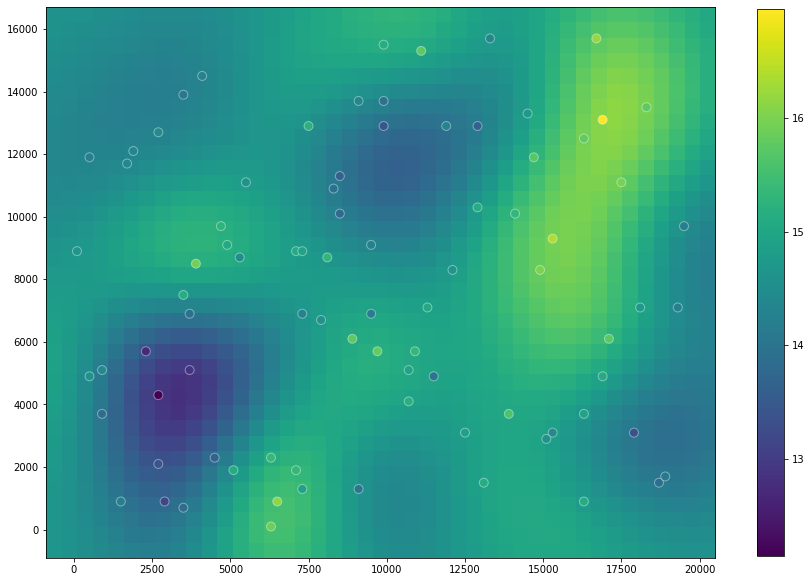

In [13]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

# Plot it all.
plt.figure(figsize=(15, 15))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

## Evaluate the model

We can compute the residual error distribution by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

<AxesSubplot:xlabel='por', ylabel='Density'>

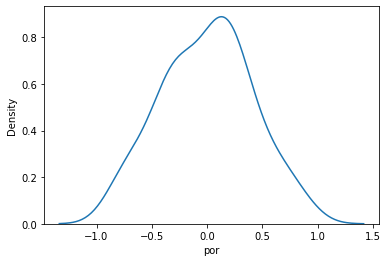

In [14]:
por_hat = gp.predict(df[['x', 'y']].values)

sns.kdeplot(por_hat - df.por)

We can also compute the RMS error:

In [15]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(df.por, por_hat))

print(f"RMS error: {rmse:.3f}")

RMS error: 0.407


## Going further

The GP model actually models the distribution, not just the mean (which for a normal distribution is also the most likely or mode, and the P50 or median).

So we can also look at samples from the distribution:

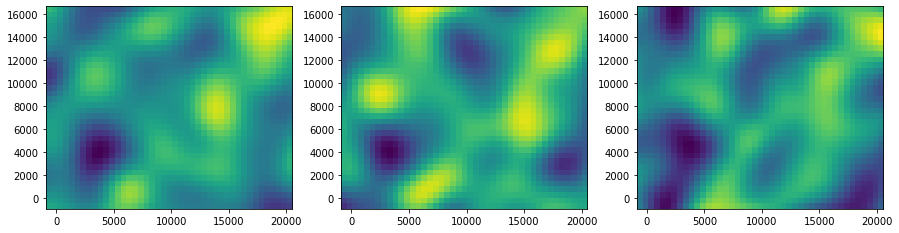

In [16]:
y_sample = gp.sample_y(X_grid, n_samples=3, random_state=42)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for ax, y_hat in zip(axs, y_sample.T):
    im = ax.imshow(y_hat.reshape(grid_x.shape), origin='lower', extent=extent)
plt.show()

Let's look at a cross-section too.

We'll want the 'wells' on there at some point, so let's add grid-cell coordinates. (A better way to do this would be to use `xarray`.)

In [17]:
df['x_grid'] = (df.x - x_min) // 500
df['y_grid'] = (df.y - y_min) // 500

Now we can get the mean and stdev of the prediction:

In [17]:
y_grid, y_std = gp.predict(X_grid, return_std=True)

y_grid = y_grid.reshape(grid_x.shape)
y_std = y_std.reshape(grid_x.shape)

Then choose a row to look at, and filter the wells down to near that row:

In [18]:
row = 19
wells = df[abs(df.y_grid - row) <= 1]

Let's check where that row and its wells are:

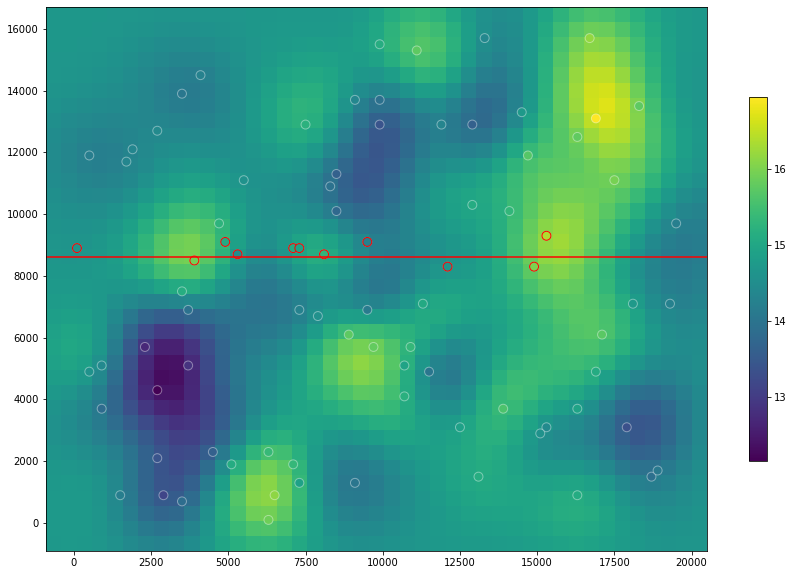

In [42]:
plt.figure(figsize=(15, 10))
im = plt.imshow(y_grid, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(df.x, df.y, c=df.por, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
pts = plt.scatter(wells.x, wells.y, c=wells.por, s=80, edgecolor='r', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.axhline(y_min + 19 * 500, c='red')
plt.show()

And compute the various things:

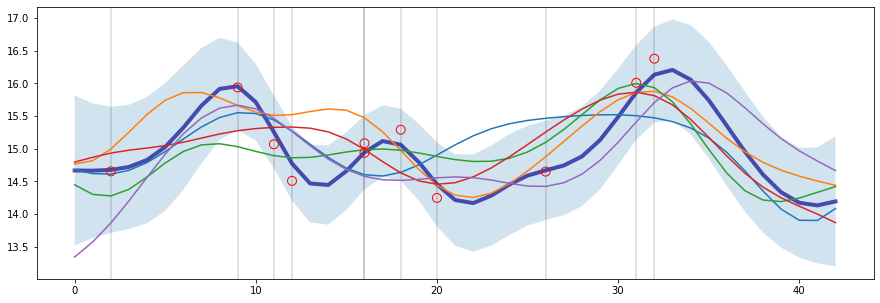

In [61]:
# Confidence interval.
phi, s = y_grid[row], y_std[row]
max_ = phi - 1.96 * s  # 95% confidence interval
min_ = phi + 1.96 * s  #     = 1.96 * stdev

# Draw some samples.
y_samples = gp.sample_y(X_grid, n_samples=5, random_state=42)

# Plot.
plt.figure(figsize=(15, 5))
for i, well in wells.iterrows():
    plt.scatter(well.x_grid, well.por, c='none', ec='r', s=80, zorder=100)
    plt.axvline(well.x_grid, c='k', alpha=0.15)
plt.plot(phi, c='darkblue', lw=4, alpha=0.67)
for sample in y_samples.T:
    plt.plot(sample.reshape(grid_x.shape)[row])
plt.fill_between(range(phi.size), min_, max_, alpha=0.2)
plt.show()

## More models

### EXERCISE

Try some other regressors in `scikit-learn`. Look at the maps they produce, and check their residuals. (You might want to write a loop to check several models.)

Which regressors produce the best maps? 

In [ ]:
# YOUR CODE HERE



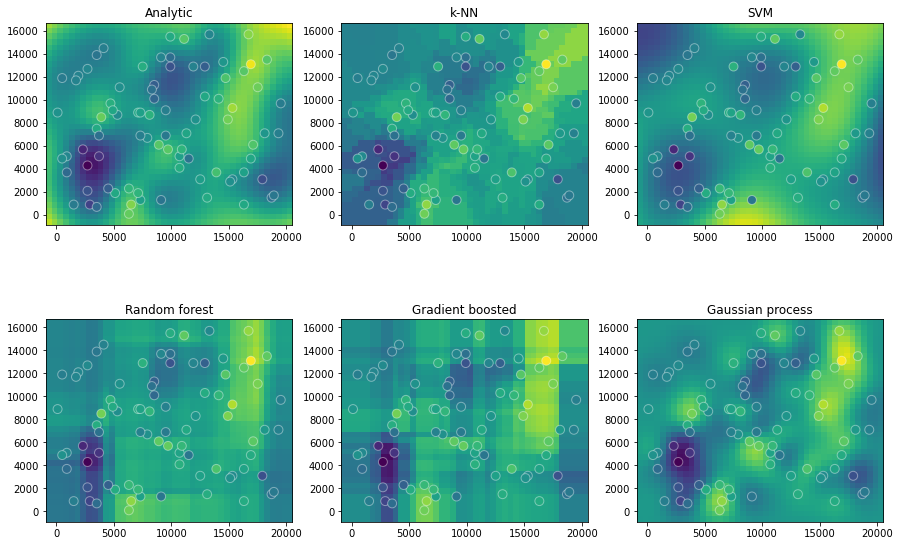

In [62]:
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from scipy.interpolate import Rbf


models =  {
    'Analytic': Rbf(df.x, df.y, df.por, smooth=0.1, function='multiquadric'), # Not an sklearn model!
    'k-NN': KNeighborsRegressor(n_neighbors=5),
    'SVM': SVR(C=10),
    'Random forest': RandomForestRegressor(max_depth=7),
    'Gradient boosted': HistGradientBoostingRegressor(min_samples_leaf=5),
    'Gaussian process': GaussianProcessRegressor(normalize_y=True, alpha=0.1, kernel=kernel),
}

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

for (model, regr), ax in zip(models.items(), axs.ravel()):
    if model == 'Analytic':
        y_grid = regr(grid_x, grid_y)  # scipy provides a function here.
    else:
        regr.fit(df[['x', 'y']].values, df.por.values)
        y_grid = regr.predict(X_grid).reshape(grid_x.shape)
    
    mi = np.min(np.hstack([y_grid.ravel(), df.por.values]))
    ma = np.max(np.hstack([y_grid.ravel(), df.por.values]))

    im = ax.imshow(y_grid, origin='lower', cmap='viridis', extent=extent, vmin=mi, vmax=ma)
    pts = ax.scatter(df.x, df.y, c=df.por, s=80, cmap='viridis', edgecolor='#ffffff66', vmin=mi, vmax=ma)
    ax.set_title(model)

plt.show()

If you're interested in this sort of thing, check out

- [This blog post](http://geologyandpython.com/ml-interpolation-method.html) on the subject.
- And [this paper](https://arxiv.org/pdf/2006.10461.pdf) on a clever CNN-based approach that incorporates Moran's I embedding.

## Superpowers with `verde` and `gstools`

The geophysical package `verde` contains still more gridding algorithms, and makes some aspects of the gridding much easier — for example reducing the nuber of points in the dataset in sensible ways. [Read about it.](https://www.leouieda.com/blog/introducing-verde.html) Better yet, [try it out.](https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb)

The geostatistical package `gstools` implements various kriging algorithms, which some people may be more familiar with. [Check it out](https://github.com/GeoStat-Framework/GSTools). 

----

<center>&copy; 2020 Agile Scientific, licensed CC-BY</center>